In [2]:
import sys
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.etl.infrastructure.crypto_client import CryptoClient # noqa

# Récupération des prix BTC-USD sur les 30 derniers jours intervalle 1 jour
client = CryptoClient()
def get_btc_usd_data(period: str = "30d", interval: str = "1d") -> pd.DataFrame:
    """
    Fetch BTC-USD market data using CryptoClient.
    """
    symbol = "BTC-USD"
    data = client.get_yahoo_data(symbol, period, interval)
    return data

btc_data = get_btc_usd_data()
display(btc_data.head(2))
# plot = btc_data['Close'].plot(title="BTC-USD Closing Prices", ylabel="Price (USD)", xlabel="Date")
# display(plot)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-09-30 00:00:00+00:00,114396.523438,114836.617188,112740.562500,114056.085938,58986330258,0.0,0.0
2025-10-01 00:00:00+00:00,114057.593750,118648.929688,113981.398438,118648.929688,71328680132,0.0,0.0


In [6]:
# utilisation du scikit-learn pour un modèle simple de régression linéaire
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression   

btc_data = get_btc_usd_data("90d", "1d")

# Préparation des données
btc_data = btc_data.reset_index()
btc_data['Date'] = btc_data['Date'].map(pd.Timestamp.toordinal)
X = btc_data[['Date']]
y = btc_data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# export en df
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(result_df.head(5))

# calcuk de l'erreur moyenne absolue
from sklearn.metrics import mean_absolute_error # noqa
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# calcul du R²
from sklearn.metrics import r2_score # noqa
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")



# Sauvegarde du modèle
import joblib
model_path = Path(project_root) / "models" / "btc_usd_linear_regression.pkl"
model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(model, model_path)


,Actual,Predicted
40,113955.359375,114465.729343
22,115374.328125,114947.801119
55,109049.289062,114064.002863
70,113214.367188,113662.276384
0,113320.085938,115536.999956


Mean Absolute Error: 3435.834599185321
R² Score: 0.0061651577506460775


['/home/sebastien/etl-amana/models/btc_usd_linear_regression.pkl']

Mean Absolute Error: 86.64
R² Score: 0.9982
           Actual      Predicted
76  108186.039062  108049.542664
77  106467.789062  106373.232488
78  107198.265625  107268.194166
79  108666.710938  108835.675650
80  110588.929688  110759.353125


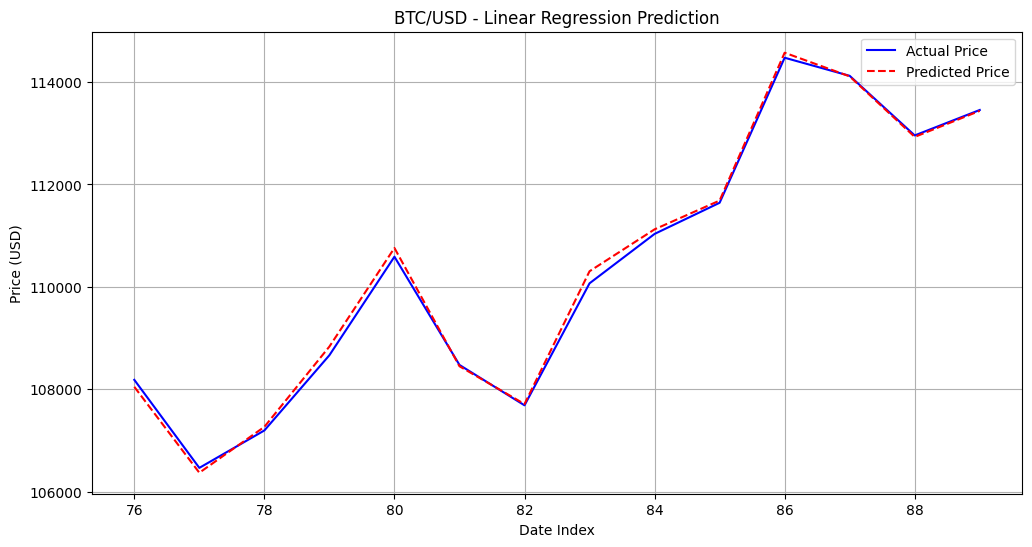

Model saved to: /home/sebastien/etl-amana/src/etl/notebooks/models/btc_usd_linear_regression.pkl


In [ ]:
# ============================================================
# BTC/USD Price Prediction - Enhanced Linear Regression Model
# ============================================================

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

btc_data = get_btc_usd_data("90d", "1d")  # Your function or yfinance
btc_data = btc_data.reset_index()
btc_data = btc_data.rename(columns={"Date": "Date", "Close": "Close"})

# Drop rows with missing values
btc_data = btc_data.dropna(subset=["Close"])

# ------------------------------------------------------------
# 2️⃣ Feature engineering
# ------------------------------------------------------------

# Daily return
btc_data["Return"] = btc_data["Close"].pct_change()

# Moving averages
btc_data["MA7"] = btc_data["Close"].rolling(window=7).mean()
btc_data["MA21"] = btc_data["Close"].rolling(window=21).mean()

# Rolling volatility
btc_data["Volatility"] = btc_data["Return"].rolling(window=7).std()

# Lagged prices (previous days)
btc_data["Lag1"] = btc_data["Close"].shift(1)
btc_data["Lag2"] = btc_data["Close"].shift(2)
btc_data["Lag3"] = btc_data["Close"].shift(3)

btc_data = btc_data.dropna()

features = ["MA7", "MA21", "Volatility", "Return", "Lag1", "Lag2", "Lag3"]
X = btc_data[features]
y = btc_data["Close"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffle for time series
)

# ------------------------------------------------------------
# 4️⃣ Train a linear regression model
# ------------------------------------------------------------

model = LinearRegression()
model.fit(X_train, y_train)

# ------------------------------------------------------------
# 5️⃣ Predictions and evaluation
# ------------------------------------------------------------

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# ------------------------------------------------------------
# 6️⃣ Compare actual vs predicted prices
# ------------------------------------------------------------

result_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred}, index=y_test.index)
print(result_df.head())

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df["Actual"], label="Actual Price", color="blue")
plt.plot(result_df.index, result_df["Predicted"], label="Predicted Price", color="red", linestyle="--")
plt.title("BTC/USD - Linear Regression Prediction")
plt.xlabel("Date Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 7️⃣ Save model
# ------------------------------------------------------------

project_root = Path.cwd()
model_path = project_root / "models" / "btc_usd_linear_regression.pkl"
model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(model, model_path)

print(f"Model saved to: {model_path}")
